In [1]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from scipy.ndimage import gaussian_filter

In [3]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [4]:
single_vector = []
cols = []
count = 0
for i in range(9443,9634):
    data = pd.read_csv('SCF' + str(i) + '.counts.txt',delim_whitespace=True)
#     print(len(data['SCF' + str(i)].values))
    single_vector.append(data['SCF' + str(i)].values)
    count += 1
    cols.append(str(i))
indexes= data['Geneid'].values

In [5]:
newdf = pd.DataFrame(single_vector)

In [6]:
newdf = newdf.transpose()
newdf.columns = cols
newdf.index = indexes

In [7]:
newdf

9443  9444  9445  9446  9447  9448  9449  9450  9451  \
ENSMUSG00000102693     0     2     0     0     0     0     0     1     0   
ENSMUSG00000064842     0     0     0     0     0     0     0     0     0   
ENSMUSG00000051951  1307   536   853  1204  1392   532   829  1154  1236   
ENSMUSG00000102851     0     1     2     3     2     1     1     5     4   
ENSMUSG00000103377     7     3     0     8     4     7     6     6     7   
...                  ...   ...   ...   ...   ...   ...   ...   ...   ...   
ENSMUSG00000094431     0     0     0     0     0     0     0     0     0   
ENSMUSG00000094621     0     0     0     1     0     0     0     0     0   
ENSMUSG00000098647     0     0     0     0     0     0     0     0     0   
ENSMUSG00000096730     0     0     0     0     0     0     0     0     0   
ENSMUSG00000095742   195   182   137   139   208   129   140   113   169   

                    9452  ...  9624  9625  9626  9627  9628  9629  9630  9631  \
ENSMUSG00000102693     0  ...     0     0     0     0     0     0     1     2   
ENSMUSG00000064842     0  ...     0     0     0     0     0     0     0     0   
ENSMUSG00000051951   686  ...   558   611  1069   840   544   752   719   931   
ENSMUSG00000102851     4  ...     3     1    11     3     1     0     5     4   
ENSMUSG00000103377     5  ...     3     1     6     9     4     3     6     8   
...                  ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
ENSMUSG00000094431     1  ...     0     0     0     0     0     0     0     0   
ENSMUSG00000094621     0  ...     0     0     0     0     0     0     0     0   
ENSMUSG00000098647     0  ...     0     0     0     0     0     0     0     0   
ENSMUSG00000096730     0  ...     0     0     0     0     0     0     1     0   
ENSMUSG00000095742   194  ...   181   113   149   215   189   129   260   276   

                    9632  9633  
ENSMUSG00000102693     0     0  
ENSMUSG00000064842     0     0  
ENSMUSG00000051951   589   864  
ENSMUSG00000102851     3     4  
ENSMUSG00000103377     3     4  
...                  ...   ...  
ENSMUSG00000094431     0     0  
ENSMUSG00000094621     0     0  
ENSMUSG00000098647     0     0  
ENSMUSG00000096730     0     0  
ENSMUSG00000095742   236   132  

[49315 rows x 191 columns]

In [8]:
print(newdf.T)  ##sample in rows and gene in columns

      ENSMUSG00000102693  ENSMUSG00000064842  ENSMUSG00000051951  \
9443                   0                   0                1307   
9444                   2                   0                 536   
9445                   0                   0                 853   
9446                   0                   0                1204   
9447                   0                   0                1392   
...                  ...                 ...                 ...   
9629                   0                   0                 752   
9630                   1                   0                 719   
9631                   2                   0                 931   
9632                   0                   0                 589   
9633                   0                   0                 864   

      ENSMUSG00000102851  ENSMUSG00000103377  ENSMUSG00000104017  \
9443                   0                   7                  13   
9444                   1                   3   

In [9]:
ages = flatten([6*np.ones(48), 12*np.ones(48), 18*np.ones(48), 24*np.ones(47)])
ko_w_group = flatten([['KO']*24, ['W']*24,['KO']*24, ['W']*24,['KO']*24, ['W']*24, ['KO']*24, ['W']*23])

In [10]:
metadata = pd.DataFrame(
    {
     'age': ages,
     'group': ko_w_group
    })
metadata.index = newdf.T.index

In [11]:
#Data filtering
samples_to_keep = ~metadata.age.isna()
counts_df = newdf.T.loc[samples_to_keep]
metadata = metadata.loc[samples_to_keep]

In [12]:
#filter out genes that have less than 10 read counts in total
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

In [13]:
#Read counts modeling with the DeseqDataSet class
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="group",
    refit_cooks=True,
    inference=inference,
)

In [14]:
dds.deseq2()

Fitting size factors...
... done in 0.17 seconds.

Fitting dispersions...
... done in 3.91 seconds.

Fitting dispersion trend curve...
... done in 1.14 seconds.

Fitting MAP dispersions...
... done in 5.10 seconds.

Fitting LFCs...
... done in 2.50 seconds.

Refitting 1110 outliers.

Fitting dispersions...
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 0.15 seconds.

Fitting LFCs...
... done in 0.11 seconds.



In [15]:
print(dds)

AnnData object with n_obs × n_vars = 191 × 36592
    obs: 'age', 'group'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'


In [16]:
'''save'''

OUTPUT_PATH='/Users/rodrigo/Library/CloudStorage/OneDrive-FloridaAtlanticUniversity/projects/haylee/hit-counts'
with open(os.path.join(OUTPUT_PATH, "dds.pkl"), "wb") as f:
    pkl.dump(dds, f)

'''load'''

# with open(os.path.join(OUTPUT_PATH, "dds.pkl"), "rb") as f:
#     dds2 = pkl.load(f)

# print(dds2)

'load'

In [17]:
#how we would access dispersions and LFCs (in natural log scale):
print(dds.varm["dispersions"])

[13.71969076  0.11710188  1.17130398 ...  0.21264679  0.02288808
  0.08965077]


In [18]:
#
print(dds.varm["LFC"])

                    intercept  group_W_vs_KO
ENSMUSG00000102693  -1.401788      -0.045135
ENSMUSG00000051951   6.677011       0.010166
ENSMUSG00000102851   1.640073      -0.529170
ENSMUSG00000103377   2.065684      -0.266583
ENSMUSG00000104017   1.691047      -0.352727
...                       ...            ...
ENSMUSG00000079794  -1.526788       0.037759
ENSMUSG00000079808   0.272774      -0.250616
ENSMUSG00000095041   8.991414      -0.032336
ENSMUSG00000063897   5.299950       0.023085
ENSMUSG00000095742   5.085542       0.009326

[36592 rows x 2 columns]


In [19]:
#  proceed with statistical tests to compute p-values and adjusted p-values for differential expresion
stat_res = DeseqStats(dds, inference=inference)

In [20]:
#PyDESeq2 computes p-values using Wald tests. This can be done using the summary() method, which runs the whole statistical analysis, cooks filtering and multiple testing adjustement included.
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: group W vs KO
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000102693     0.152288       -0.065117  0.883563 -0.073698  0.941251   
ENSMUSG00000051951   797.787972        0.014667  0.071836  0.204170  0.838221   
ENSMUSG00000102851     4.346360       -0.763431  0.249940 -3.054460  0.002255   
ENSMUSG00000103377     7.274234       -0.384598  0.169511 -2.268859  0.023277   
ENSMUSG00000104017     4.870088       -0.508878  0.182358 -2.790536  0.005262   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000079794     0.102325        0.054475  1.162654  0.046854  0.962630   
ENSMUSG00000079808     1.263141       -0.361562  0.322457 -1.121272  0.262172   
ENSMUSG00000095041  7907.038472       -0.046651  0.096306 -0.484398  0.628104   
ENSMUSG00000063897   203.109048        0.033305  0.034864  0.955272  0.339440   
ENSMUSG00000095742   162.954974        0.013454  0.064664

... done in 1.12 seconds.



In [21]:
stat_res.results_df.to_csv(os.path.join(OUTPUT_PATH, "results.csv"))

In [22]:
stat_res.lfc_shrink(coeff="group_W_vs_KO")

Fitting MAP LFCs...
/Users/rodrigo/anaconda3/envs/pydeseq2/lib/python3.12/site-packages/pydeseq2/utils.py:1209: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


Shrunk log2 fold change & Wald test p-value: group W vs KO
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000102693     0.152288       -0.000270  0.057977 -0.073698  0.941251   
ENSMUSG00000051951   797.787972        0.005865  0.045238  0.204170  0.838221   
ENSMUSG00000102851     4.346360       -0.021240  0.063232 -3.054460  0.002255   
ENSMUSG00000103377     7.274234       -0.023493  0.065768 -2.268859  0.023277   
ENSMUSG00000104017     4.870088       -0.242883  0.265661 -2.790536  0.005262   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000079794     0.102325        0.000615  0.064078  0.046854  0.962630   
ENSMUSG00000079808     1.263141       -0.005539  0.056482 -1.121272  0.262172   
ENSMUSG00000095041  7907.038472       -0.041257  0.076857 -0.484398  0.628104   
ENSMUSG00000063897   203.109048        0.020246  0.031163  0.955272  0.339440   
ENSMUSG00000095742   162.954974        0.003785  0

... done in 4.68 seconds.



Note: running Wald test on shrunk LFCs. Some sequencing datasets show better performance with the testing separated from the use of the LFC prior.
Running Wald tests...
... done in 1.62 seconds.



Log2 fold change & Wald test p-value: group W vs KO
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000102693     0.152288       -0.000270  0.881347  0.000000  1.000000   
ENSMUSG00000051951   797.787972        0.005865  0.071837  0.000000  1.000000   
ENSMUSG00000102851     4.346360       -0.021240  0.244319  0.000000  1.000000   
ENSMUSG00000103377     7.274234       -0.023493  0.167233  0.000000  1.000000   
ENSMUSG00000104017     4.870088       -0.242883  0.179814 -0.794615  0.426838   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000079794     0.102325        0.000615  1.164177  0.000000  1.000000   
ENSMUSG00000079808     1.263141       -0.005539  0.315476  0.000000  1.000000   
ENSMUSG00000095041  7907.038472       -0.041257  0.096306  0.000000  1.000000   
ENSMUSG00000063897   203.109048        0.020246  0.034877  0.000000  1.000000   
ENSMUSG00000095742   162.954974        0.003785  0.064670

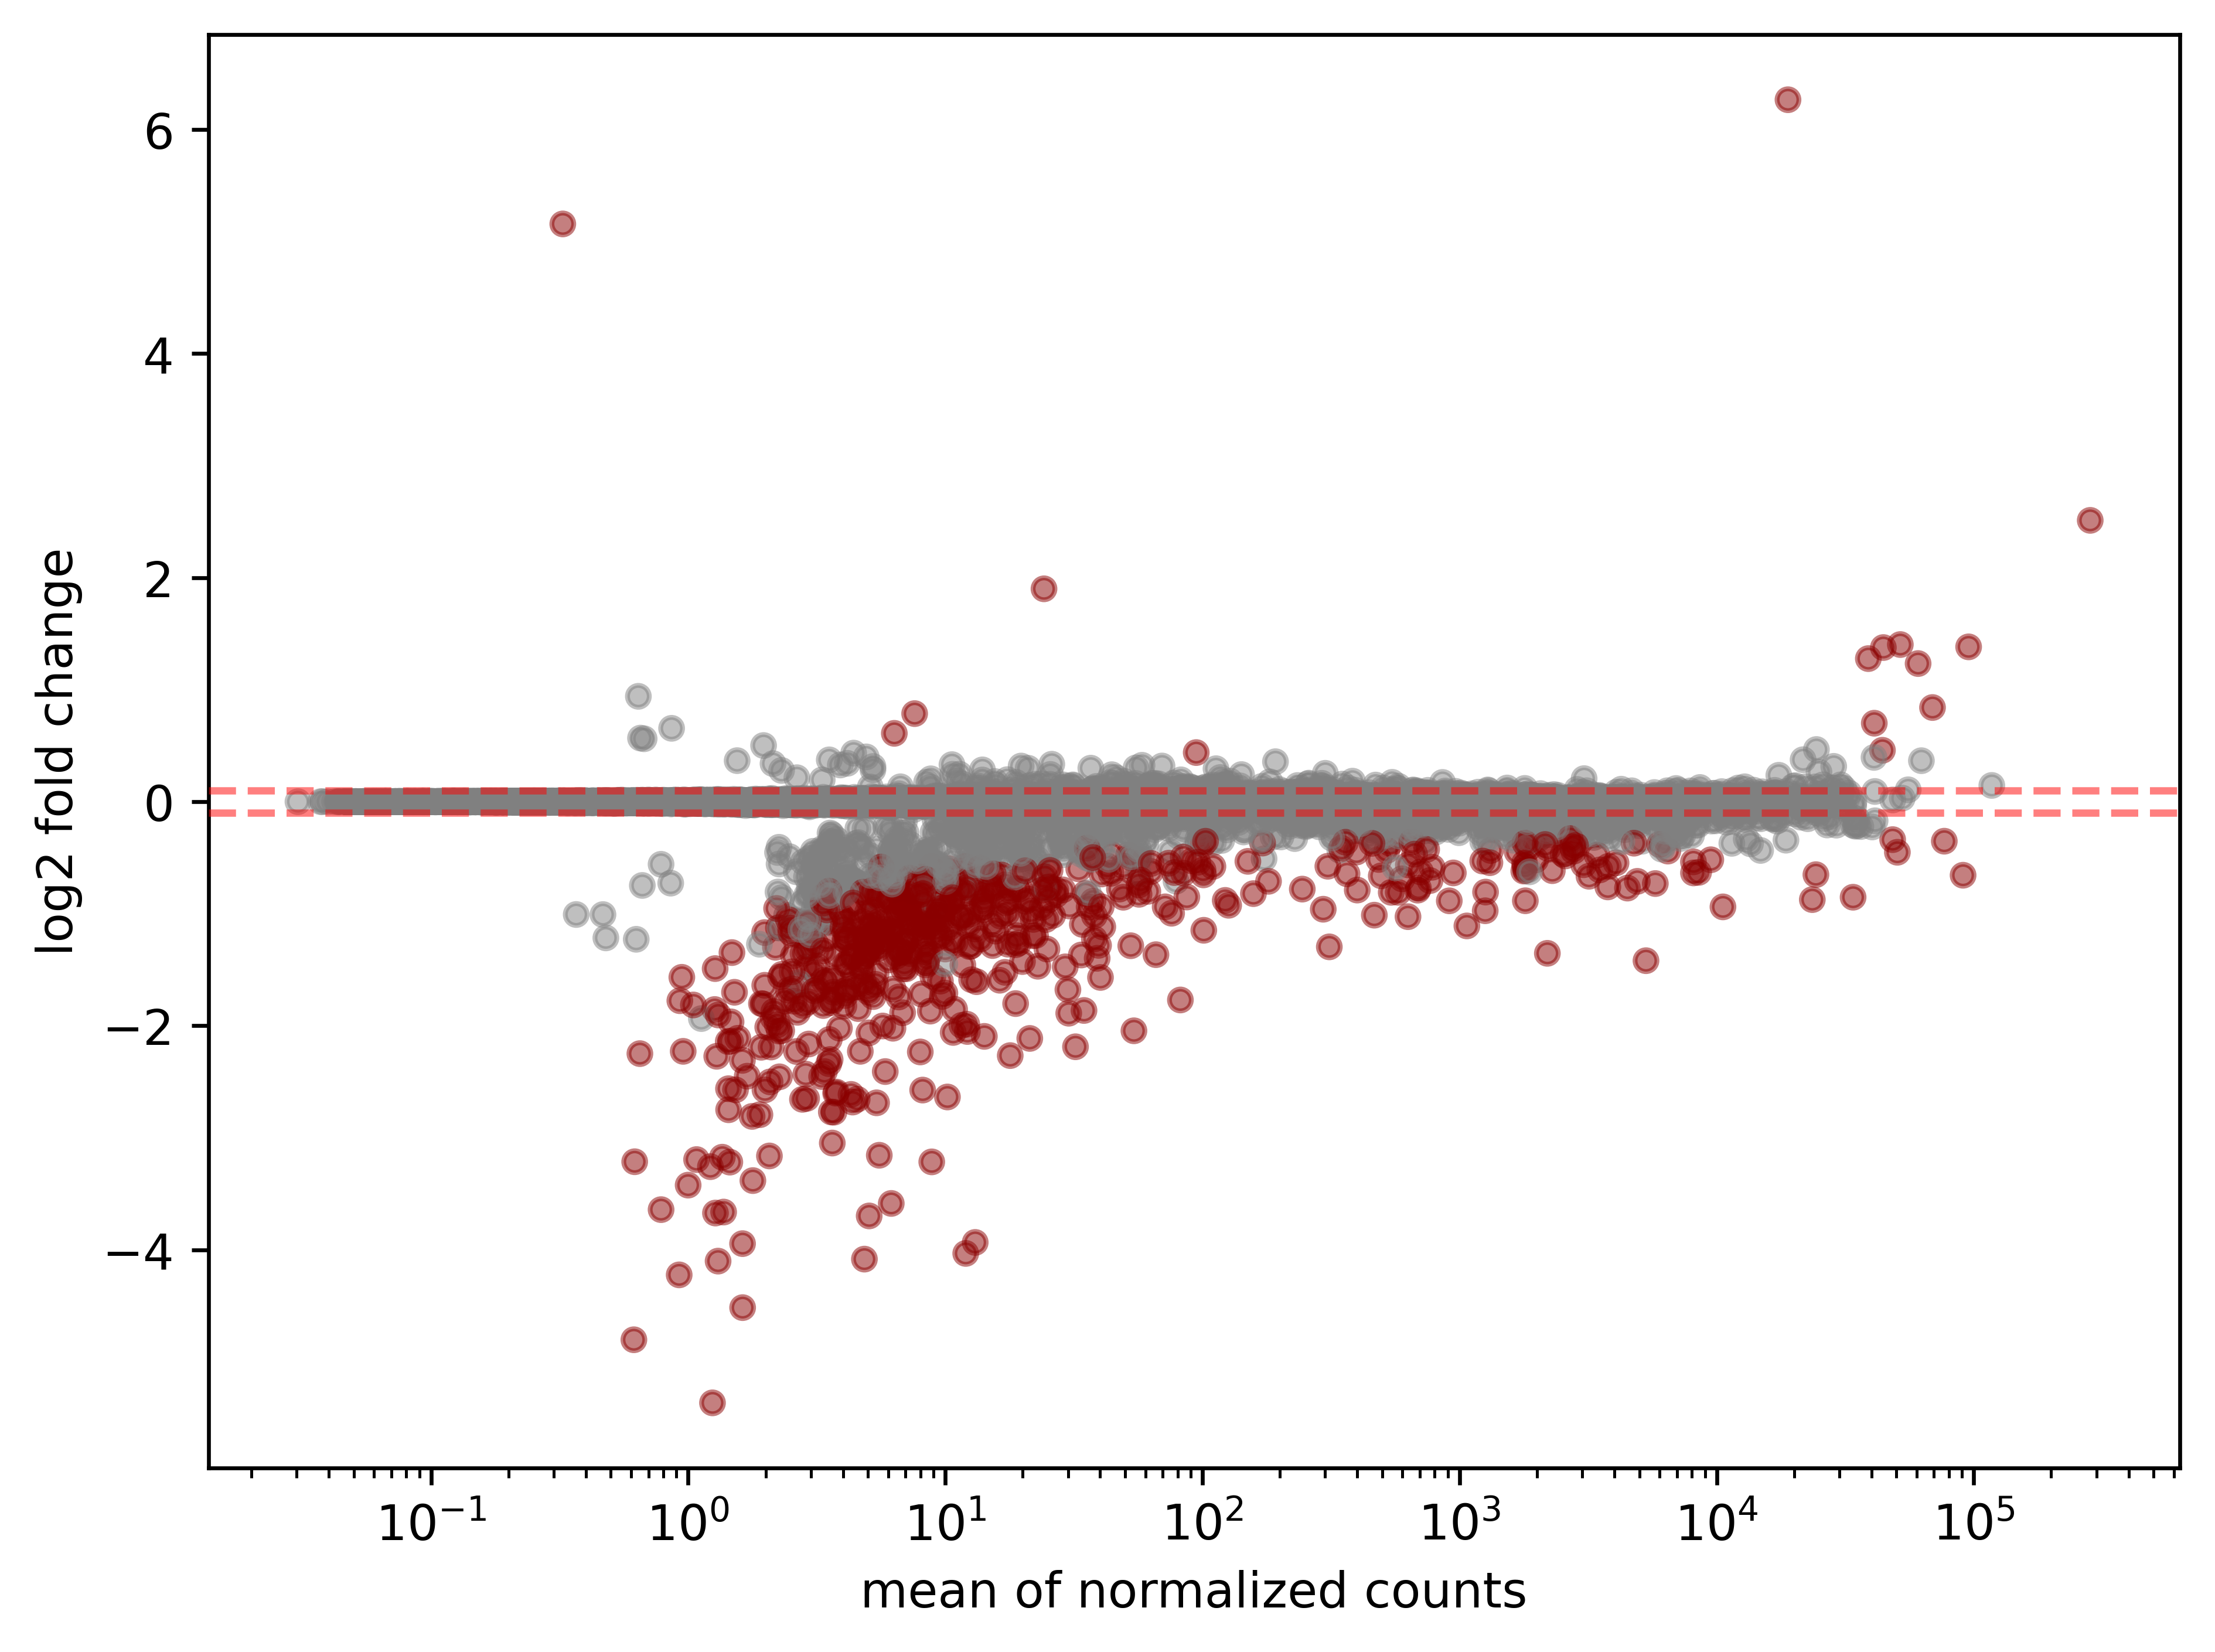

In [23]:
stat_res.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
stat_res.plot_MA(s=20)
plt.savefig("log2fold_counts.png")

In [44]:
# Extract results
res = stat_res.results_df
res

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000102693     0.152288       -0.000270  0.881347  0.000000  1.000000   
ENSMUSG00000051951   797.787972        0.005865  0.071837  0.000000  1.000000   
ENSMUSG00000102851     4.346360       -0.021240  0.244319  0.000000  1.000000   
ENSMUSG00000103377     7.274234       -0.023493  0.167233  0.000000  1.000000   
ENSMUSG00000104017     4.870088       -0.242883  0.179814 -0.794615  0.426838   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000079794     0.102325        0.000615  1.164177  0.000000  1.000000   
ENSMUSG00000079808     1.263141       -0.005539  0.315476  0.000000  1.000000   
ENSMUSG00000095041  7907.038472       -0.041257  0.096306  0.000000  1.000000   
ENSMUSG00000063897   203.109048        0.020246  0.034877  0.000000  1.000000   
ENSMUSG00000095742   162.954974        0.003785  0.064670  0.000000  1.000000   

                    padj  
ENSMUSG00000102693   1.0  
ENSMUSG00000051951   1.0  
ENSMUSG00000102851   1.0  
ENSMUSG00000103377   1.0  
ENSMUSG00000104017   1.0  
...                  ...  
ENSMUSG00000079794   NaN  
ENSMUSG00000079808   1.0  
ENSMUSG00000095041   1.0  
ENSMUSG00000063897   1.0  
ENSMUSG00000095742   1.0  

[36592 rows x 6 columns]

In [52]:
res[res['baseMean']>1]

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000051951   797.787972        0.005865  0.071837  0.000000  1.000000   
ENSMUSG00000102851     4.346360       -0.021240  0.244319  0.000000  1.000000   
ENSMUSG00000103377     7.274234       -0.023493  0.167233  0.000000  1.000000   
ENSMUSG00000104017     4.870088       -0.242883  0.179814 -0.794615  0.426838   
ENSMUSG00000103025     1.703555        0.008690  0.217902  0.000000  1.000000   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000079834   146.612548       -0.018346  0.027883  0.000000  1.000000   
ENSMUSG00000079808     1.263141       -0.005539  0.315476  0.000000  1.000000   
ENSMUSG00000095041  7907.038472       -0.041257  0.096306  0.000000  1.000000   
ENSMUSG00000063897   203.109048        0.020246  0.034877  0.000000  1.000000   
ENSMUSG00000095742   162.954974        0.003785  0.064670  0.000000  1.000000   

                    padj  
ENSMUSG00000051951   1.0  
ENSMUSG00000102851   1.0  
ENSMUSG00000103377   1.0  
ENSMUSG00000104017   1.0  
ENSMUSG00000103025   1.0  
...                  ...  
ENSMUSG00000079834   1.0  
ENSMUSG00000079808   1.0  
ENSMUSG00000095041   1.0  
ENSMUSG00000063897   1.0  
ENSMUSG00000095742   1.0  

[25431 rows x 6 columns]

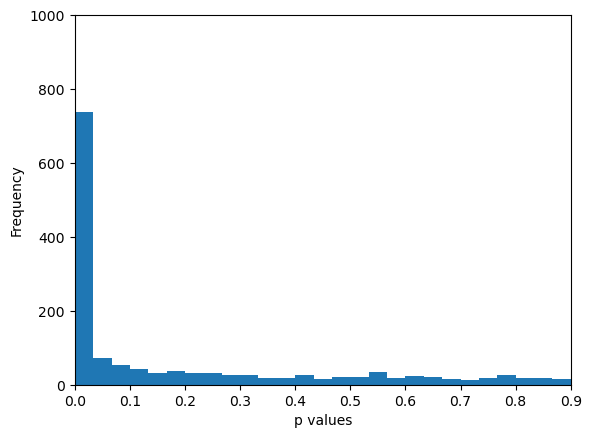

In [57]:
plt.hist(res[res['baseMean']>1]['pvalue'],30);
plt.xlim([0,0.9])
plt.ylim([0,1000])
plt.xlabel('p values')
plt.ylabel('Frequency')
plt.savefig("hist_ps.png")

In [26]:
res

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000102693     0.152288       -0.000270  0.881347  0.000000  1.000000   
ENSMUSG00000051951   797.787972        0.005865  0.071837  0.000000  1.000000   
ENSMUSG00000102851     4.346360       -0.021240  0.244319  0.000000  1.000000   
ENSMUSG00000103377     7.274234       -0.023493  0.167233  0.000000  1.000000   
ENSMUSG00000104017     4.870088       -0.242883  0.179814 -0.794615  0.426838   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000079794     0.102325        0.000615  1.164177  0.000000  1.000000   
ENSMUSG00000079808     1.263141       -0.005539  0.315476  0.000000  1.000000   
ENSMUSG00000095041  7907.038472       -0.041257  0.096306  0.000000  1.000000   
ENSMUSG00000063897   203.109048        0.020246  0.034877  0.000000  1.000000   
ENSMUSG00000095742   162.954974        0.003785  0.064670  0.000000  1.000000   

                    padj  
ENSMUSG00000102693   1.0  
ENSMUSG00000051951   1.0  
ENSMUSG00000102851   1.0  
ENSMUSG00000103377   1.0  
ENSMUSG00000104017   1.0  
...                  ...  
ENSMUSG00000079794   NaN  
ENSMUSG00000079808   1.0  
ENSMUSG00000095041   1.0  
ENSMUSG00000063897   1.0  
ENSMUSG00000095742   1.0  

[36592 rows x 6 columns]

In [27]:
res = res[res.baseMean >= 10]

In [28]:
res

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000051951   797.787972        0.005865  0.071837  0.000000  1.000000   
ENSMUSG00000102331   173.644648       -0.510751  0.158785 -2.586841  0.009686   
ENSMUSG00000025902    95.835458        0.054500  0.064067  0.000000  1.000000   
ENSMUSG00000033845   569.122495       -0.014215  0.018576  0.000000  1.000000   
ENSMUSG00000102275    17.540878       -0.499916  0.131065 -3.051274  0.002279   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000061654   453.468080       -0.001058  0.118912  0.000000  1.000000   
ENSMUSG00000079834   146.612548       -0.018346  0.027883  0.000000  1.000000   
ENSMUSG00000095041  7907.038472       -0.041257  0.096306  0.000000  1.000000   
ENSMUSG00000063897   203.109048        0.020246  0.034877  0.000000  1.000000   
ENSMUSG00000095742   162.954974        0.003785  0.064670  0.000000  1.000000   

                        padj  
ENSMUSG00000051951  1.000000  
ENSMUSG00000102331  0.502215  
ENSMUSG00000025902  1.000000  
ENSMUSG00000033845  1.000000  
ENSMUSG00000102275  0.133767  
...                      ...  
ENSMUSG00000061654  1.000000  
ENSMUSG00000079834  1.000000  
ENSMUSG00000095041  1.000000  
ENSMUSG00000063897  1.000000  
ENSMUSG00000095742  1.000000  

[17611 rows x 6 columns]

In [29]:
sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5)]


In [30]:
sigs

baseMean  log2FoldChange     lfcSE       stat  \
ENSMUSG00000100862      56.135642       -0.514220  0.077164  -5.368074   
ENSMUSG00000102070      52.910382       -0.501829  0.099020  -4.058066   
ENSMUSG00000102386     126.439278       -0.925443  0.149665  -5.515279   
ENSMUSG00000026083    3186.477704       -0.666369  0.060692  -9.331913   
ENSMUSG00000099924      25.449109       -0.758631  0.140988  -4.671547   
...                           ...             ...       ...        ...   
ENSMUSG00000109695      71.610878       -0.939336  0.091740  -9.149042   
ENSMUSG00000024661   33921.864021       -0.853599  0.053001 -14.218483   
ENSMUSG00000064341   90835.799526       -0.657313  0.067823  -8.217205   
ENSMUSG00000064345   69083.472559        0.839824  0.081897   9.033596   
ENSMUSG00000064351  283635.337208        2.510450  0.061923  38.926364   

                          pvalue          padj  
ENSMUSG00000100862  7.958182e-08  9.627974e-06  
ENSMUSG00000102070  4.948069e-05  3.830668e-03  
ENSMUSG00000102386  3.482262e-08  4.503459e-06  
ENSMUSG00000026083  1.039773e-20  5.086451e-18  
ENSMUSG00000099924  2.989399e-06  2.810701e-04  
...                          ...           ...  
ENSMUSG00000109695  5.744062e-20  2.423564e-17  
ENSMUSG00000024661  7.036155e-46  1.484365e-42  
ENSMUSG00000064341  2.083012e-16  6.222122e-14  
ENSMUSG00000064345  1.661216e-19  6.520079e-17  
ENSMUSG00000064351  0.000000e+00  0.000000e+00  

[207 rows x 6 columns]

In [31]:
dds.layers['normed_counts']

array([[0.00000000e+00, 1.16432575e+03, 0.00000000e+00, ...,
        1.27060277e+04, 2.03111149e+02, 1.73713482e+02],
       [1.63117106e+00, 4.37153843e+02, 8.15585528e-01, ...,
        6.36727622e+03, 1.57408007e+02, 1.48436566e+02],
       [0.00000000e+00, 7.26289208e+02, 1.70290553e+00, ...,
        5.39139890e+03, 1.88171061e+02, 1.16649029e+02],
       ...,
       [1.66675391e+00, 7.75873947e+02, 3.33350783e+00, ...,
        5.69029786e+03, 2.25011778e+02, 2.30012040e+02],
       [0.00000000e+00, 5.02259869e+02, 2.55819967e+00, ...,
        3.20968785e+03, 1.53491980e+02, 2.01245041e+02],
       [0.00000000e+00, 7.64560432e+02, 3.53963163e+00, ...,
        2.95913204e+03, 1.93794832e+02, 1.16807844e+02]])

In [32]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])


In [33]:
dds.layers['log1p']


array([[0.        , 7.06075594, 0.        , ..., 9.44991048, 5.31866469,
        5.16314739],
       [0.96742902, 6.08257009, 0.59640802, ..., 8.7590841 , 5.06517403,
        5.006872  ],
       [0.        , 6.58932421, 0.99432732, ..., 8.59274563, 5.24265169,
        4.76770586],
       ...,
       [0.98086197, 6.65527811, 1.46637734, ..., 8.6466936 , 5.42058711,
        5.44246983],
       [0.        , 6.22110667, 1.26925471, ..., 8.07424048, 5.04014219,
        5.30948004],
       [0.        , 6.64060816, 1.51284587, ..., 7.99298916, 5.27194686,
        4.76905485]])

In [34]:
sigs


baseMean  log2FoldChange     lfcSE       stat  \
ENSMUSG00000100862      56.135642       -0.514220  0.077164  -5.368074   
ENSMUSG00000102070      52.910382       -0.501829  0.099020  -4.058066   
ENSMUSG00000102386     126.439278       -0.925443  0.149665  -5.515279   
ENSMUSG00000026083    3186.477704       -0.666369  0.060692  -9.331913   
ENSMUSG00000099924      25.449109       -0.758631  0.140988  -4.671547   
...                           ...             ...       ...        ...   
ENSMUSG00000109695      71.610878       -0.939336  0.091740  -9.149042   
ENSMUSG00000024661   33921.864021       -0.853599  0.053001 -14.218483   
ENSMUSG00000064341   90835.799526       -0.657313  0.067823  -8.217205   
ENSMUSG00000064345   69083.472559        0.839824  0.081897   9.033596   
ENSMUSG00000064351  283635.337208        2.510450  0.061923  38.926364   

                          pvalue          padj  
ENSMUSG00000100862  7.958182e-08  9.627974e-06  
ENSMUSG00000102070  4.948069e-05  3.830668e-03  
ENSMUSG00000102386  3.482262e-08  4.503459e-06  
ENSMUSG00000026083  1.039773e-20  5.086451e-18  
ENSMUSG00000099924  2.989399e-06  2.810701e-04  
...                          ...           ...  
ENSMUSG00000109695  5.744062e-20  2.423564e-17  
ENSMUSG00000024661  7.036155e-46  1.484365e-42  
ENSMUSG00000064341  2.083012e-16  6.222122e-14  
ENSMUSG00000064345  1.661216e-19  6.520079e-17  
ENSMUSG00000064351  0.000000e+00  0.000000e+00  

[207 rows x 6 columns]

In [35]:
dds_sigs = dds[:, sigs.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 191 × 207
    obs: 'age', 'group'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks', 'log1p'

In [36]:
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs_names)

/Users/rodrigo/anaconda3/envs/pydeseq2/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rodrigo/anaconda3/envs/pydeseq2/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


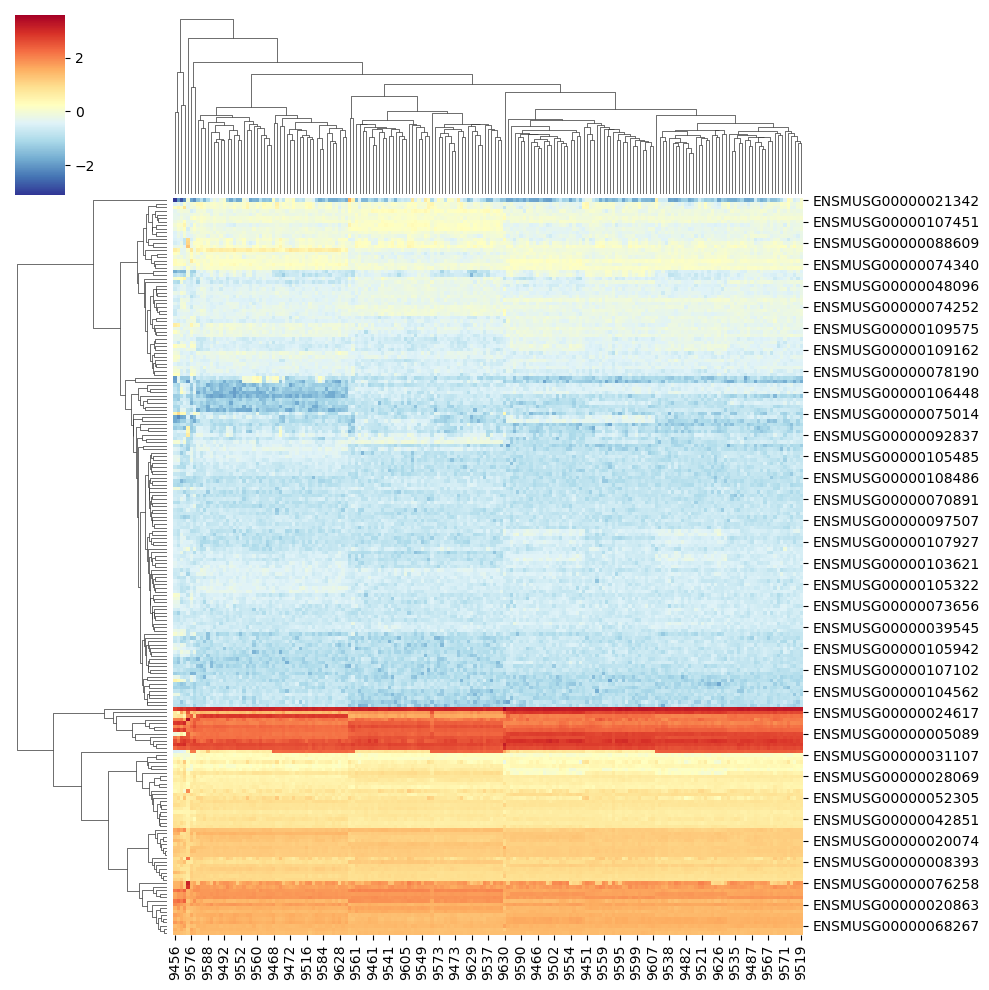

In [37]:
sns.clustermap(grapher, z_score=1, cmap = 'RdYlBu_r')
plt.savefig("clustermap_zcored.png")

In [38]:
import plotly.graph_objects as go
import plotly.express as px

In [39]:
res['negative_log_pval'] = np.log10(res['pvalue']) * (-1)

fig = go.Figure()
trace1 = go.Scatter(
 x=res['log2FoldChange'],
 y=res['negative_log_pval'],
 mode='markers',
 name='KO vs W',
 hovertext=list(res.index)
)


fig.add_trace(trace1)
# fig.add_trace(trace2)
# fig.add_trace(trace3)
fig.update_layout(title='Volcano plot')
fig.update_xaxes(
    range=[-2,0.5],  # sets the range of xaxis
)
fig.update_yaxes(
    range=[-0.5,5],  # sets the range of xaxis
)

fig.write_image("volcano.png")
# fig.show()

/Users/rodrigo/anaconda3/envs/pydeseq2/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/hz/4rjmmhhx0cs465y7hrvc5cdh0000gr/T/ipykernel_20638/1837329550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['negative_log_pval'] = np.log10(res['pvalue']) * (-1)


/Users/rodrigo/anaconda3/envs/pydeseq2/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10

/var/folders/hz/4rjmmhhx0cs465y7hrvc5cdh0000gr/T/ipykernel_20638/1844410300.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



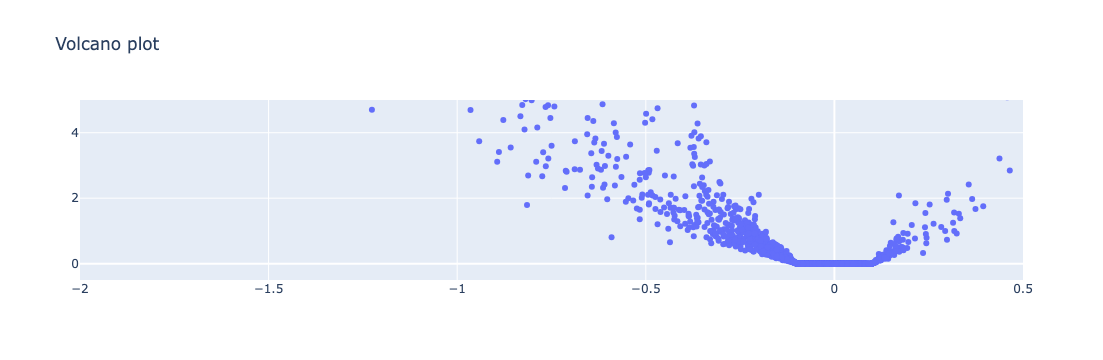

In [40]:
res['negative_log_pval'] = np.log10(res['pvalue']) * (-1)

fig = go.Figure()
trace1 = go.Scatter(
 x=res['log2FoldChange'],
 y=res['negative_log_pval'],
 mode='markers',
 name='KO vs W',
 hovertext=list(res.index)
)


fig.add_trace(trace1)
# fig.add_trace(trace2)
# fig.add_trace(trace3)
fig.update_layout(title='Volcano plot')
fig.update_xaxes(
    range=[-2,0.5],  # sets the range of xaxis
)
fig.update_yaxes(
    range=[-0.5,5],  # sets the range of xaxis
)
fig.show()

In [41]:
!pip install bioinfokit

In [42]:
from bioinfokit import analys, visuz

In [43]:
visuz.GeneExpression.volcano(df=res, lfc='log2FoldChange', pv='pvalue',lfc_thr=(1, 2), pv_thr=(0.05, 0.01))

/Users/rodrigo/anaconda3/envs/pydeseq2/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10

/Users/rodrigo/anaconda3/envs/pydeseq2/lib/python3.12/site-packages/bioinfokit/visuz.py:1569: SyntaxWarning:

invalid escape sequence '\i'



KeyError: 'nan'

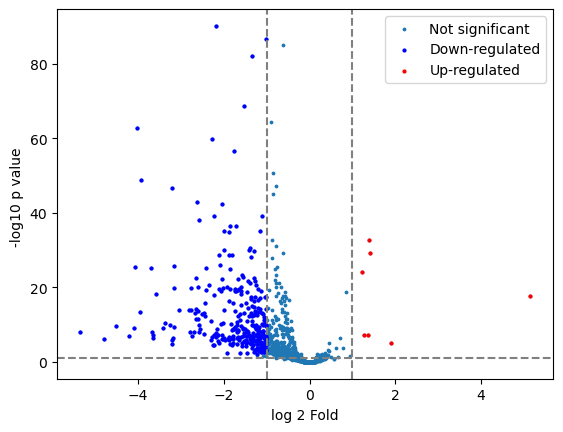

In [71]:
res['negative_log_pval'] = np.log10(res['pvalue']) * (-1)

plt.scatter(x=res['log2FoldChange'],y=res['negative_log_pval'],s=3,label="Not significant")

# # highlight down- or up- regulated genes
down = res[(res['log2FoldChange']<=-1)&(res['pvalue']<=0.01)]
up = res[(res['log2FoldChange']>=1)&(res['pvalue']<=0.01)]

plt.scatter(x=down['log2FoldChange'],y=down['negative_log_pval'],s=4,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['negative_log_pval'],s=4,label="Up-regulated",color="red")

plt.xlabel("log 2 Fold")
plt.ylabel("-log10 p value ")
plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(1,color="grey",linestyle="--")
plt.legend()
plt.savefig('volcano.png')

In [ ]:
### https://hemtools.readthedocs.io/en/latest/content/Bioinformatics_Core_Competencies/Volcanoplot.html

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


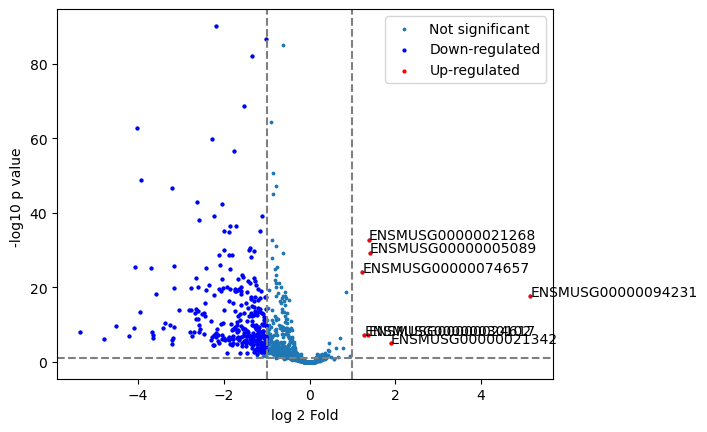

In [81]:
from adjustText import adjust_text

res['negative_log_pval'] = np.log10(res['pvalue']) * (-1)

plt.scatter(x=res['log2FoldChange'],y=res['negative_log_pval'],s=3,label="Not significant")

# # highlight down- or up- regulated genes
down = res[(res['log2FoldChange']<=-1)&(res['pvalue']<=0.01)]
up = res[(res['log2FoldChange']>=1)&(res['pvalue']<=0.01)]

plt.scatter(x=down['log2FoldChange'],y=down['negative_log_pval'],s=4,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['negative_log_pval'],s=4,label="Up-regulated",color="red")

texts = []
for i,r in up.iterrows():
    texts.append(plt.text(x=r['log2FoldChange'],y=r['negative_log_pval'],s=i))
# adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xlabel("log 2 Fold")
plt.ylabel("-log10 p value ")
plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(1,color="grey",linestyle="--")
plt.legend()
plt.savefig('volcano_names.png')